In [ ]:
!pip uninstall pytorch_forecasting
!pip install pytorch_forecasting==0.10.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.4/141.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.2/308.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.4 MB/s eta 0:00:00
     ━━━━━━

In [ ]:
!pip uninstall -y pytorch-lightning
!pip install pytorch-lightning==1.9.4

Found existing installation: pytorch-lightning 1.9.5
Uninstalling pytorch-lightning-1.9.5:
  Successfully uninstalled pytorch-lightning-1.9.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
!pip uninstall torchvision
!pip install torchvision>=0.8.2

Found existing installation: torchvision 0.15.2+cu118
Uninstalling torchvision-0.15.2+cu118:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.15.2+cu118.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.60cfec8e.so.11.0
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.70530407.so.11
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libz.e3d3156c.so.1
    /usr/local/lib/python3.10/dist-packages/torchvision/*
Proceed (Y/n)? Y
  Successfully uninstalled torchvision-0.15.2+cu118
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-forecasting 0.10.3 requires torch<2.0,>=1.7, but you have torch 2.0.1 which i

In [ ]:
import pandas as pd
import os
import torch
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_forecasting.data.encoders import TorchNormalizer
from pytorch_lightning.callbacks import ModelCheckpoint
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler

In [ ]:
TimeSeriesData = pd.read_csv(r"/content/FullGermanModelWithLag.csv")
TimeSeriesData['Timeseries_ID'] = TimeSeriesData['Timeseries_ID'].astype(str)
TimeSeriesData['year'] = TimeSeriesData['year'].astype(str)
TimeSeriesData['quarter'] = TimeSeriesData['quarter'].astype(str)
TimeSeriesData['dayofweek'] = TimeSeriesData['dayofweek'].astype(str)
TimeSeriesData['month'] = TimeSeriesData['month'].astype(str)

In [ ]:
columns_to_keep = ['Time_index', 'Timeseries_ID', 'ExecutionTime', 'DeliveryStart', 'Weighted Average Price', 'dayofweek', 'year', 'Day-Ahead Price', 'quarter', 'LoadForecast', 'GenerationForecast', 'ReneweableForecast']
# Select the desired columns
TimeSeriesData = TimeSeriesData[columns_to_keep]

In [ ]:
#scale data
cols_to_scale = ['Weighted Average Price', 'Day-Ahead Price', 'ReneweableForecast', 'LoadForecast', 'GenerationForecast']

scaler = RobustScaler()
TimeSeriesData_scaled = scaler.fit_transform(TimeSeriesData[cols_to_scale])

TimeSeriesData[cols_to_scale] = TimeSeriesData_scaled

In [ ]:
TimeSeriesData.head()

,Time_index,Timeseries_ID,ExecutionTime,DeliveryStart,Weighted Average Price,dayofweek,year,Day-Ahead Price,quarter,LoadForecast,GenerationForecast,ReneweableForecast
0,0,1,2021-01-01 14:00:00,2021-01-01 17:00:00,-0.626116,4,2021,-0.638857,1,-1.798527,-0.214889,-1.028447
1,1,1,2021-01-01 14:05:00,2021-01-01 17:00:00,-0.626161,4,2021,-0.638857,1,-1.798527,-0.214889,-1.028447
2,2,1,2021-01-01 14:10:00,2021-01-01 17:00:00,-0.625893,4,2021,-0.638857,1,-1.798527,-0.214889,-1.028447
3,3,1,2021-01-01 14:15:00,2021-01-01 17:00:00,-0.621708,4,2021,-0.638857,1,-1.783193,-0.214889,-1.048098
4,4,1,2021-01-01 14:20:00,2021-01-01 17:00:00,-0.614381,4,2021,-0.638857,1,-1.783193,-0.214889,-1.048098


In [ ]:
TimeSeriesData['ExecutionTime'] = pd.to_datetime(TimeSeriesData['ExecutionTime'])

# set the date before which you want to keep the rows
cutoff_date = '2022-12-13'

# create the new DataFrame by filtering rows based on ExecutionTime column
TimeSeriesData = TimeSeriesData[TimeSeriesData['ExecutionTime'] <= cutoff_date]

#TimeSeriesData = TimeSeriesData.dropna(subset=['Day-Ahead Price'])

print(TimeSeriesData.shape)

(21330, 12)


In [ ]:
max_prediction_length = 24  # Predicting 12-12-2022
obs_per_day = 30
validation_days = 14
max_encoder_length = obs_per_day * 710  # from 02-01-2021 to 12-12-2022

training_cutoff = TimeSeriesData["Time_index"].max() - (obs_per_day * validation_days)

training = TimeSeriesDataSet(
    TimeSeriesData[lambda x: x.Time_index <= training_cutoff],
    time_idx="Time_index",
    target="Weighted Average Price",
    group_ids=["Timeseries_ID"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["Timeseries_ID"],
    time_varying_known_categoricals=['year','dayofweek', 'quarter'],
    time_varying_known_reals=['Time_index', 'Day-Ahead Price', 'ReneweableForecast', 'LoadForecast', 'GenerationForecast'],
    time_varying_unknown_reals=['Weighted Average Price'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True)

validation_datasets = []

for i in range(validation_days):
    validation_start = training_cutoff + 1 + (i * obs_per_day)
    validation_datasets.append(
        TimeSeriesDataSet.from_dataset(
            training,
            TimeSeriesData[lambda x: x.Time_index < validation_start + obs_per_day],
            predict=True,
            stop_randomization=True)
    )
    
print(f"Training cutoff: {training_cutoff}")

# create dataloaders for our model
batch_size = 32
# if you have a strong GPU, feel free to increase the number of workers
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloaders = [validation_day.to_dataloader(train=False, num_workers=4, batch_size=batch_size * 10) for validation_day in validation_datasets]


Training cutoff: 20909


In [ ]:
import warnings
warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*", category=UserWarning, module="sklearn")


In [ ]:

class SmallAndSmartTFT(TemporalFusionTransformer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.val_avg_loss = None

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.logger.experiment.add_scalar("Loss/Train", avg_loss, self.current_epoch)

    def validation_step(self, batch, batch_idx, dataloader_idx=None):
        loss = super().validation_step(batch, batch_idx)
        return loss["loss"], dataloader_idx   
            
    def validation_epoch_end(self, outputs):

        losses = []
        for i in range(validation_days):
            day_losses = [x[0][0] for x in outputs if len(x) > 0 and x[0][1] == i]
            if day_losses:
                losses.append(torch.stack(day_losses).mean())

        if losses:
            avg_loss = torch.stack(losses).mean()
            self.val_avg_loss = avg_loss.item()
            self.log("val_avg_loss", avg_loss)  # Log the metric
            self.logger.experiment.add_scalar("Loss/Validation", avg_loss, self.current_epoch)
        else:
            print("No losses found for this epoch")

pl.seed_everything(42)            
early_stop_callback = EarlyStopping(monitor="val_avg_loss", min_delta=1e-4, patience=2, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")
checkpoint_callback = ModelCheckpoint(
    monitor='val_avg_loss',
    mode='min')  
        
trainer = pl.Trainer(
    max_epochs=45,
    accelerator='gpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger)

tft = SmallAndSmartTFT.from_dataset(
    training,
    learning_rate=0.01,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.3,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloaders)


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
INFO:pytorch_li

Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_avg_loss improved. New best score: 0.062
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_avg_loss improved by 0.016 >= min_delta = 0.0001. New best score: 0.046


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_avg_loss did not improve in the last 2 records. Best score: 0.046. Signaling Trainer to stop.


In [ ]:
!zip -r version_0.zip /content/lightning_logs/lightning_logs/version_4

  adding: content/lightning_logs/lightning_logs/version_4/ (stored 0%)
  adding: content/lightning_logs/lightning_logs/version_4/checkpoints/ (stored 0%)
  adding: content/lightning_logs/lightning_logs/version_4/checkpoints/epoch=2-step=1917.ckpt (deflated 25%)
  adding: content/lightning_logs/lightning_logs/version_4/hparams.yaml (deflated 90%)
  adding: content/lightning_logs/lightning_logs/version_4/projector_config.pbtxt (deflated 74%)
  adding: content/lightning_logs/lightning_logs/version_4/events.out.tfevents.1685200228.055511002ffb.2448.4 (deflated 5%)
  adding: content/lightning_logs/lightning_logs/version_4/03195/ (stored 0%)
  adding: content/lightning_logs/lightning_logs/version_4/03195/Timeseries_ID/ (stored 0%)
  adding: content/lightning_logs/lightning_logs/version_4/03195/Timeseries_ID/metadata.tsv (stored 0%)
  adding: content/lightning_logs/lightning_logs/version_4/03195/Timeseries_ID/tensors.tsv (stored 0%)
  adding: content/lightning_logs/lightning_logs/version_4/03

In [ ]:
from google.colab import files

files.download("/content/version_0.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
best_model_path='/content/epoch=3-step=2556.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


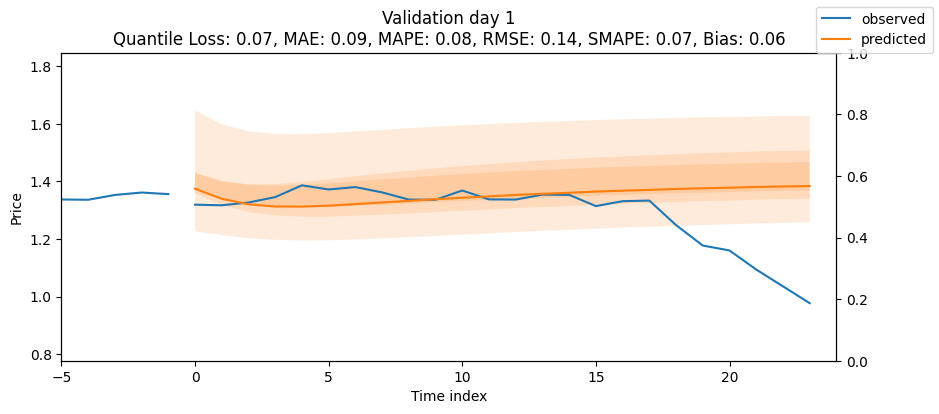

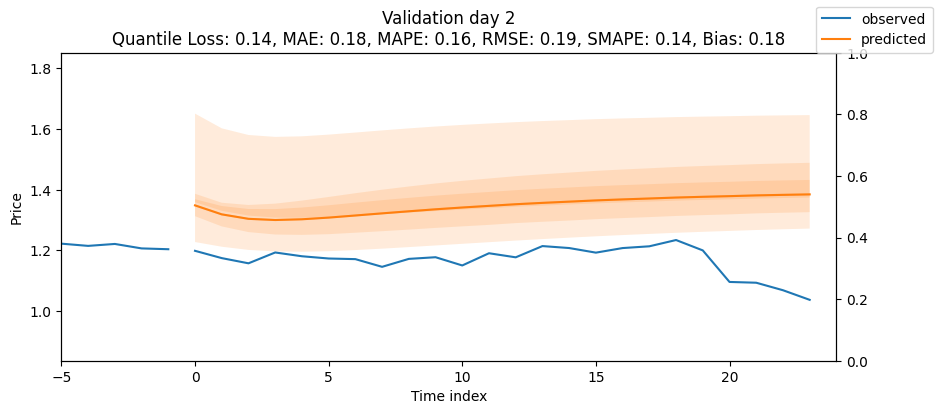

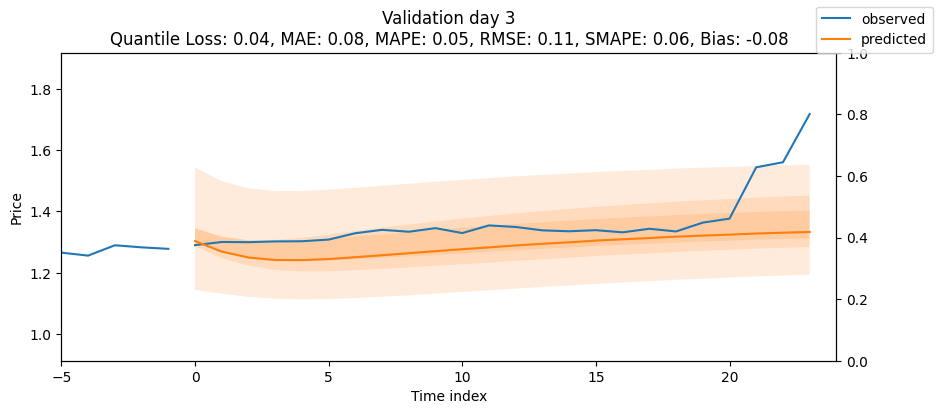

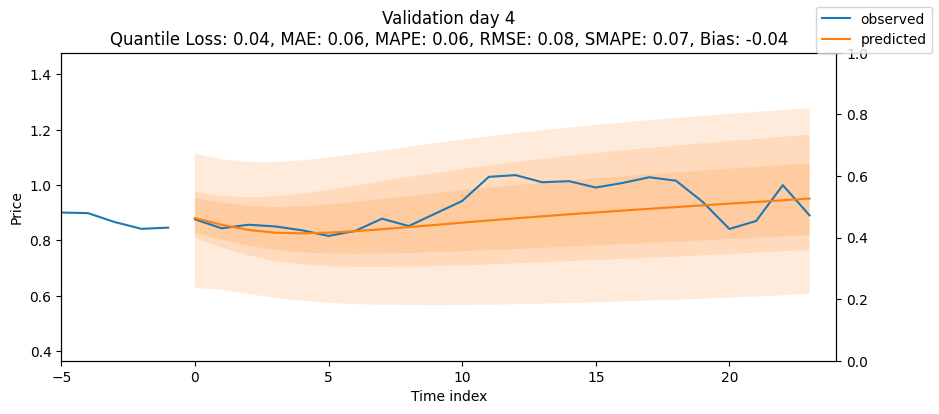

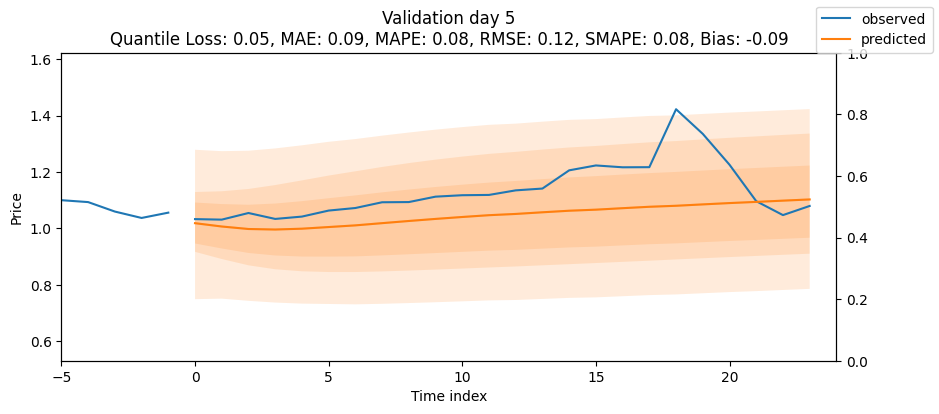

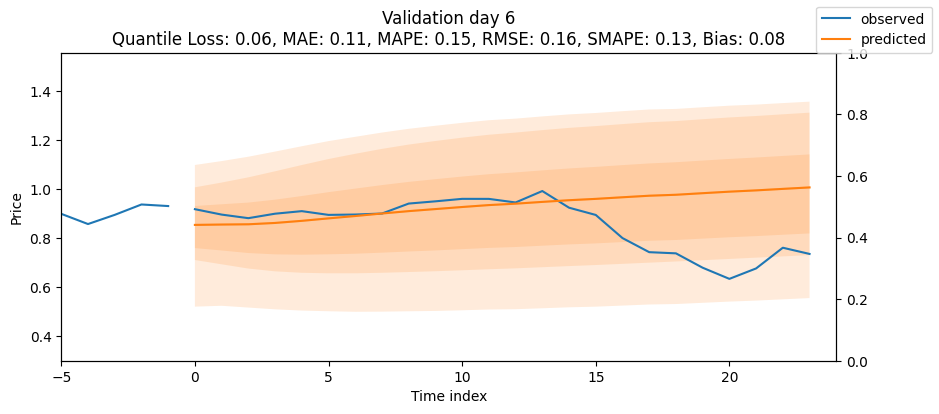

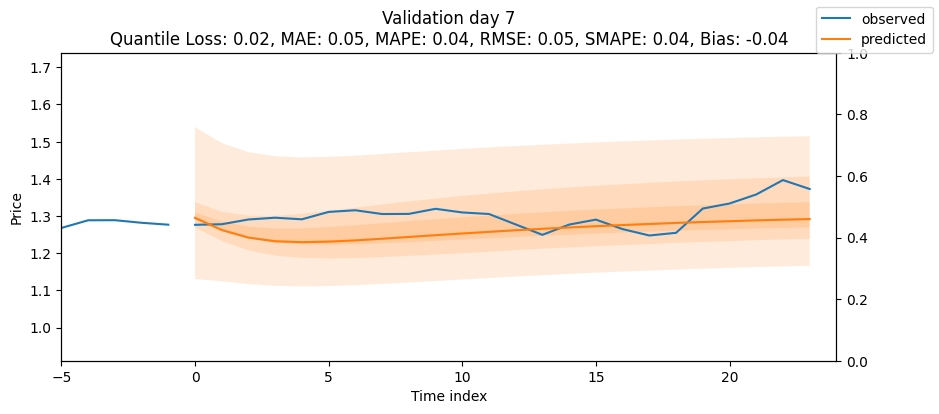

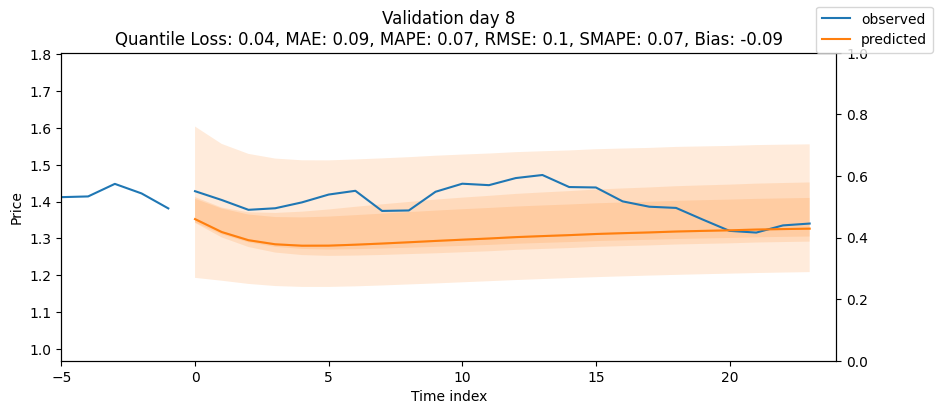

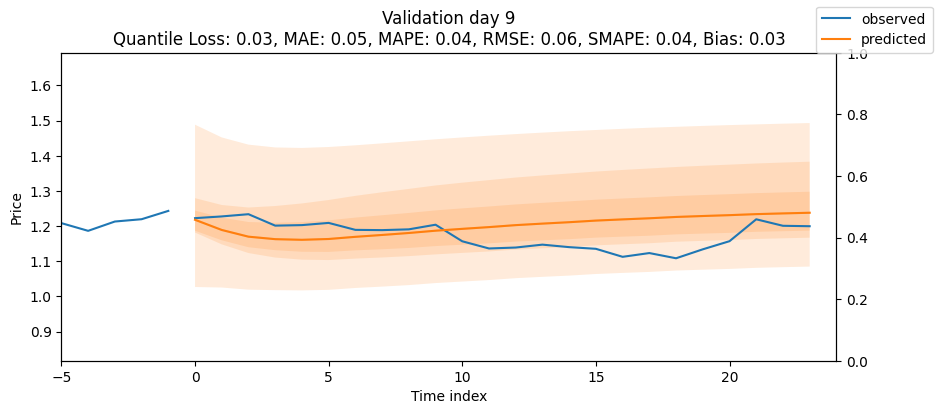

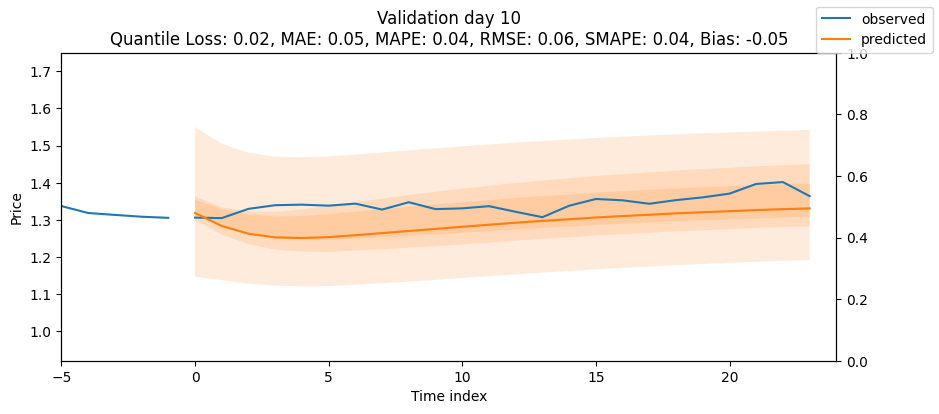

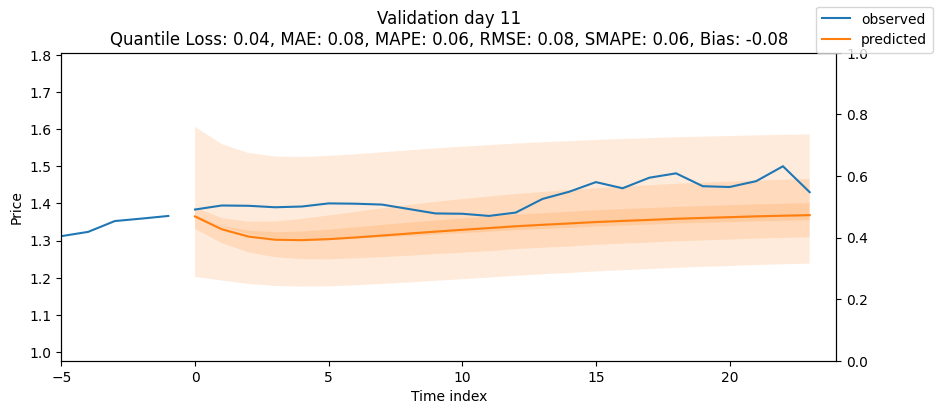

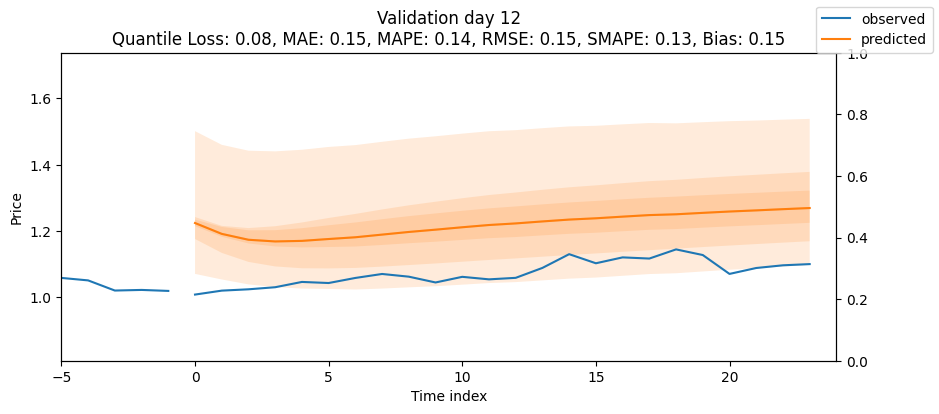

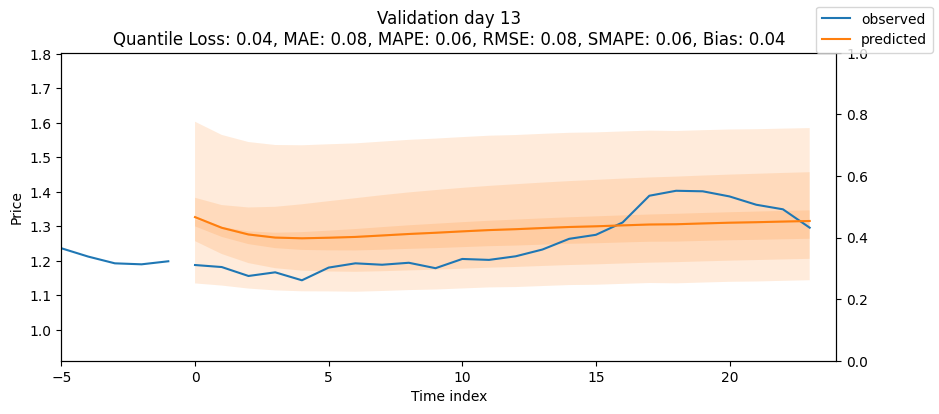

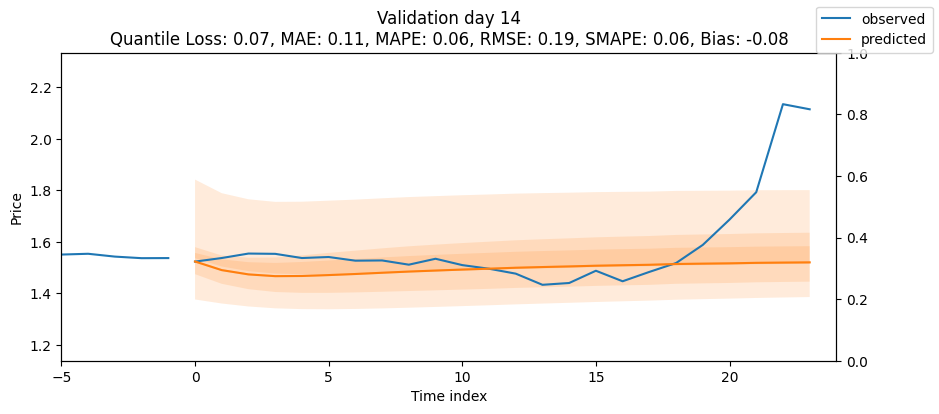

0.05290037300437689
mae: 0.09005684804703508
mape: 0.07677584753504821
rmse: 0.11356777484927859
SMAPE: 0.07451379618474416
Forecast Bias: -0.001093274780682155


In [ ]:
#%%
#Get mean and variance for "Weighted Average Price"

variable_index = 0
center = scaler.center_[variable_index]
scale = scaler.scale_[variable_index]

#%%

total_average_loss = 0
mae_sum = 0
mape_sum = 0
rmse_sum = 0
smape_sum = 0
bias_sum = 0

for i, validation_day in enumerate(val_dataloaders):
    raw_predictions, x = best_tft.predict(validation_day, mode="raw", return_x=True)
    
    ### COMMENT OUT FOR UNSCALED ###
    #x['encoder_target'] = x['encoder_target'] * scale + center
    #x['decoder_target'] = x['decoder_target'] * scale + center
    #prediction_tensor = raw_predictions['prediction']
    #unscaled_prediction_tensor = prediction_tensor * scale + center
    #out = {"prediction": unscaled_prediction_tensor}
    ###
    
    ### COMMENT OUT FOR SCALED ####
    out = {"prediction": raw_predictions['prediction']}
    ###
    
    min_val = torch.minimum(torch.min(out['prediction'][:, :, 0]), x['decoder_target'].min())
    max_val = torch.maximum(torch.max(out['prediction'][:, :, -1]), x['decoder_target'].max())

    # create two y-axes, one on the left and one on the right
    fig, ax_left = plt.subplots(figsize=(10, 4))
    ax_right = ax_left.twinx()
    
    # plot the data on the left axis
    best_tft.plot_prediction(x, out, idx=0, plot_attention=False, add_loss_to_title=False, ax=ax_left)

    # plot additional data on the right axis
    ax_left.set_ylabel("Price")
    
    # set the limits for the left y-axis to zoom in
    plt.xlim(-5, 24)
    ax_left.set_ylim([min_val - 0.2, max_val + 0.2])
    
    Quantile_loss = QuantileLoss()
    loss_value = Quantile_loss(out['prediction'], x['decoder_target'])
    
    mae = np.mean(np.abs(np.array(out['prediction'][0,:,3]) - np.array(x['decoder_target'])))
    mape = np.mean(np.abs((np.array(out['prediction'][0,:,3]) - np.array(x['decoder_target'])) / np.array(x['decoder_target'])))
    rmse = np.sqrt(np.mean(np.square(np.array(out['prediction'][0,:,3]) - np.array(x['decoder_target']))))
    smape = np.mean(2 * np.abs(np.array(out['prediction'][0,:,3]) - np.array(x['decoder_target'])) / (np.abs(np.array(out['prediction'][0,:,3])) + np.abs(np.array(x['decoder_target']))))
    bias = np.mean(np.array(out['prediction'][0,:,3]) - np.array(x['decoder_target']))
    mae_sum += mae
    mape_sum += mape
    rmse_sum += rmse
    smape_sum += smape
    bias_sum += bias
    
    title = 'Validation day ' + str(i+1) + "\nQuantile Loss: " + str(round(loss_value.item(), 2)) + ", MAE: " + str(round(mae, 2)) + ", MAPE: " + str(round(mape, 2)) + ", RMSE: " + str(round(rmse, 2)) + ", SMAPE: " + str(round(smape, 2)) + ", Bias: " + str(round(bias,2))
    plt.title(title)
    
    total_average_loss = total_average_loss + loss_value.item()
    # show the plot
    plt.show()
    
print(total_average_loss/14)
mae_avg = mae_sum / 14
mape_avg = mape_sum / 14
rmse_avg = rmse_sum / 14
smape_avg = smape_sum / 14
bias_avg = bias_sum / 14

print(f'mae: {mae_avg}')
print(f'mape: {mape_avg}')
print(f'rmse: {rmse_avg}')
print(f'SMAPE: {smape_avg}')
print(f'Forecast Bias: {bias_avg}')